# Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

In [3]:
duration = data[duration_col].to_numpy().squeeze()
event = data[event_col].to_numpy().squeeze()

In [4]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [5]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X = feature_scaling(X)

In [6]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize clients 

In [7]:
N_SPLITS = 3
DATA_SPLIT_IDX = [np.arange(data.shape[0])] * N_SPLITS  #np.array_split(np.arange(data.shape[0]), N_SPLITS)

In [8]:
from utils.client import Client 

participants = [] 

rho = 1

for idx in DATA_SPLIT_IDX:
    # Init client objects with mutually exclusive data samples 
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    # Apply data pre-processing steps 
    client.preprocess_data(train_test_split=False)
    # Initialize model and parameters 
    client.init_model(local_knots=False, knots=knots)

    participants.append(client)

2025-05-22 17:29:13.074158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initialize parameters

In [9]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration)

# Initialize beta coefficients
beta = init_beta(X, y)

In [10]:
for client in participants:
    client.set_params({"beta": beta, "gamma": gamma})

# Client fitting

In [11]:
# For convergence
# - Initial global parameters
z_beta = np.zeros_like(client.beta)
z_gamma = np.zeros_like(client.gamma)
# - Exponential moving average
z_beta_prev = z_beta.copy()
z_gamma_prev = z_gamma.copy()

In [ ]:
def relative_change(params, params_other):
    return np.linalg.norm(params - params_other) 
    

def has_converged(params, params_other, eps=1e-2):
    # Scale the difference to adapt the convergence criteria to parameter magnitude. 
    # This measures the relative difference between estimates, ie, the significane of the change 
    # relative to the size of the parameters. Useful if parameters can vary in scale.
    return relative_change(params, params_other) <= eps 


# GLobal iterations 
n_iter = 15000

losses = []
for i in range(n_iter):

    update_beta, update_gamma, last_local_losses = [], [], []
    for client in participants:

        # Fit client 
        client.fit_model(z_beta, z_gamma)
        # Gather update parameters 
        update_beta.append(client.beta)
        update_gamma.append(client.gamma)

        # Trace training loss per client 
        last_local_losses.append(client.loss)

    # Average training loss across clients 
    losses.append(np.mean(last_local_losses))
    
    # Global update
    z_beta = np.mean(update_beta, axis=0)
    z_gamma = np.mean(update_gamma, axis=0)
    
    if has_converged(z_beta_prev, z_beta) and has_converged(z_gamma_prev, z_gamma):
        print(f"Converged after {i} iterations")
        break 

    if i % (n_iter / 10) == 0:
        change_beta = relative_change(z_beta_prev, z_beta)  
        change_gamma = relative_change(z_gamma_prev, z_gamma)  
        print(f"Iter {i}: {change_beta}; {change_gamma}")

    # Update previous parameter estimate 
    z_beta_prev = z_beta
    z_gamma_prev = z_gamma

plt.figure()
plt.plot(losses)

# Global model 

In [13]:
z_beta

array([[-0.17556182, -0.31482871,  0.09797603, -0.07980018, -0.12819564,
        -0.03646753,  0.24887696]])

In [14]:
z_gamma

array([[-6.2461903 , -4.98450125, -3.87976525, -2.05881743, -1.6657439 ,
        -1.37899391, -1.23410545]])

# Reference model

Converged after 5714 iterations


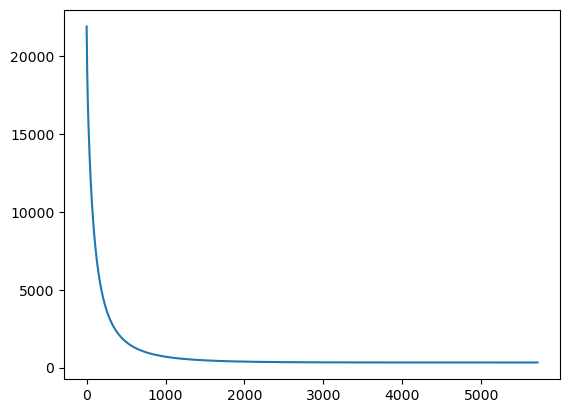

In [15]:
from utils.model import Model

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.01, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [16]:
ref_model.beta

array([[-0.1827855 , -0.32915616,  0.09825834, -0.07604485, -0.13582215,
        -0.03850739,  0.25675514]], dtype=float32)

In [17]:
z_beta

array([[-0.17556182, -0.31482871,  0.09797603, -0.07980018, -0.12819564,
        -0.03646753,  0.24887696]])

In [18]:
ref_model.gamma

array([[-6.27012  , -5.004872 , -3.9073408, -2.0790188, -1.6947267,
        -1.3955883, -1.2582062]], dtype=float32)

In [19]:
z_gamma

array([[-6.2461903 , -4.98450125, -3.87976525, -2.05881743, -1.6657439 ,
        -1.37899391, -1.23410545]])

In [20]:
# Training until 5K epochs: 0.06939954423736899
relative_change(z_beta, ref_model.beta)

0.019900504766799852

In [21]:
# Training until 5K epochs: 0.11927933753618518
relative_change(z_gamma, ref_model.gamma)

0.062067125045071135